To begin copy this notebook to your own drive:

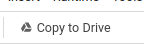


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [3]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:08<00:00, 56.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 59.9MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 845.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 67.4 MB/s eta 0:00

In [5]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [7]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [36]:
len(small_eval_dataset)

25000

In [8]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [9]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-9-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [10]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [11]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_rate=0):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          prob_zero = drop_rate
          mask = torch.bernoulli(torch.full(self.embeddings.weight.data.shape, prob_zero))
          self.embeddings.weight.data = self.embeddings.weight.data * mask

          glove_embeddings = np.load("glove.npy")
          embedding_dim = glove_embeddings.shape[1]

          #self.classifier = nn.Linear(embedding_dim, self.num_labels)
          #hidden_size = 128
          self.classifier = nn.Sequential(
              #nn.Dropout(p=drop_rate),
              #nn.Linear(embedding_dim, embedding_dim),
              #nn.Linear(embedding_dim, embedding_dim),
              #nn.ReLU(),
              nn.Linear(embedding_dim, embedding_dim),
              #nn.ReLU(),
              nn.Linear(embedding_dim, self.num_labels),
              #nn.ReLU(),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      #masked_embeddings = embeddings * attention_masks.unsqueeze(-1)
      #avg = torch.mean(masked_embeddings, dim=1)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [20]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10 , #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-3 ,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [14]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6127, 'learning_rate': 0.0009893367455747495, 'epoch': 0.32}
{'loss': 0.5248, 'learning_rate': 0.000978673491149499, 'epoch': 0.64}
{'loss': 0.5136, 'learning_rate': 0.0009680102367242482, 'epoch': 0.96}
{'eval_loss': 0.5097435116767883, 'eval_accuracy': 0.79696, 'eval_runtime': 10.9691, 'eval_samples_per_second': 2279.134, 'eval_steps_per_second': 142.491, 'epoch': 1.0}
{'loss': 0.5042, 'learning_rate': 0.0009573469822989977, 'epoch': 1.28}
{'loss': 0.4912, 'learning_rate': 0.0009466837278737471, 'epoch': 1.6}
{'loss': 0.4946, 'learning_rate': 0.0009360204734484965, 'epoch': 1.92}
{'eval_loss': 0.5245146751403809, 'eval_accuracy': 0.7754, 'eval_runtime': 13.6156, 'eval_samples_per_second': 1836.126, 'eval_steps_per_second': 114.795, 'epoch': 2.0}
{'loss': 0.4897, 'learning_rate': 0.0009253572190232459, 'epoch': 2.24}
{'loss': 0.4803, 'learning_rate': 0.0009146939645979954, 'epoch': 2.56}
{'loss': 0.4891, 'learning_rate': 0.0009040307101727447, 'epoch': 2.88}
{'eval_loss': 0

TrainOutput(global_step=46890, training_loss=0.47473373950023495, metrics={'train_runtime': 985.659, 'train_samples_per_second': 760.912, 'train_steps_per_second': 47.572, 'train_loss': 0.47473373950023495, 'epoch': 30.0})

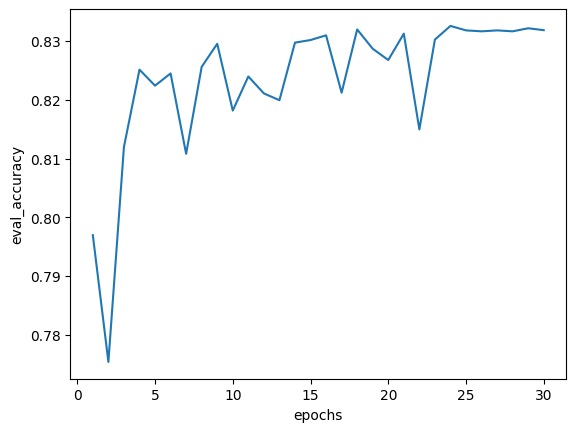

In [16]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
x = []
y = []
for log in log_history:
  if 'eval_accuracy' in log:
    x.append(log['epoch'])
    y.append(log['eval_accuracy'])
acc_drop_0 = max(y)
plt.plot(x, y)
plt.ylabel('eval_accuracy')
plt.xlabel('epochs')
plt.show()


In [21]:
acc_drop = [acc_drop_0]
abc = []
for i in range(1, 6):
  model = DAN(i*0.1)

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  trainer.train()
  y = []
  for log in log_history:
    if 'eval_accuracy' in log:
      y.append(log['eval_accuracy'])
  print(y)
  abc.append(y)
  acc_drop.append(max(y))


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.62, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5432, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5284, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.5070978999137878, 'eval_accuracy': 0.8038, 'eval_runtime': 11.1893, 'eval_samples_per_second': 2234.272, 'eval_steps_per_second': 139.687, 'epoch': 1.0}
{'loss': 0.5219, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5173, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5174, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.4995320439338684, 'eval_accuracy': 0.80784, 'eval_runtime': 11.1707, 'eval_samples_per_second': 2237.996, 'eval_steps_per_second': 139.92, 'epoch': 2.0}
{'loss': 0.5158, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.5071, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.5212, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0.49

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6273, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.559, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5468, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.525938093662262, 'eval_accuracy': 0.77928, 'eval_runtime': 11.3693, 'eval_samples_per_second': 2198.911, 'eval_steps_per_second': 137.476, 'epoch': 1.0}
{'loss': 0.5401, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5348, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5368, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.5101463198661804, 'eval_accuracy': 0.79308, 'eval_runtime': 10.8738, 'eval_samples_per_second': 2299.109, 'eval_steps_per_second': 143.74, 'epoch': 2.0}
{'loss': 0.5328, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.5272, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.5378, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0.5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6327, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5738, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5606, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.5252042412757874, 'eval_accuracy': 0.78528, 'eval_runtime': 10.2244, 'eval_samples_per_second': 2445.142, 'eval_steps_per_second': 152.87, 'epoch': 1.0}
{'loss': 0.5562, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5484, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5501, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.5115243196487427, 'eval_accuracy': 0.79512, 'eval_runtime': 11.2587, 'eval_samples_per_second': 2220.506, 'eval_steps_per_second': 138.826, 'epoch': 2.0}
{'loss': 0.5514, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.5434, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.5529, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6382, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5894, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5782, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.5490827560424805, 'eval_accuracy': 0.75508, 'eval_runtime': 11.1037, 'eval_samples_per_second': 2251.508, 'eval_steps_per_second': 140.764, 'epoch': 1.0}
{'loss': 0.5731, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5664, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5677, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.5442456007003784, 'eval_accuracy': 0.75428, 'eval_runtime': 11.079, 'eval_samples_per_second': 2256.519, 'eval_steps_per_second': 141.078, 'epoch': 2.0}
{'loss': 0.5679, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.558, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.5725, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6449, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.603, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5939, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
{'eval_loss': 0.5514375567436218, 'eval_accuracy': 0.75792, 'eval_runtime': 10.3474, 'eval_samples_per_second': 2416.055, 'eval_steps_per_second': 151.052, 'epoch': 1.0}
{'loss': 0.5899, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.5791, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.5851, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
{'eval_loss': 0.5398690104484558, 'eval_accuracy': 0.76428, 'eval_runtime': 11.386, 'eval_samples_per_second': 2195.672, 'eval_steps_per_second': 137.273, 'epoch': 2.0}
{'loss': 0.5828, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.5763, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.5867, 'learning_rate': 0.0007120921305182341, 'epoch': 2.88}
{'eval_loss': 0.

[0.83256, 0.83256, 0.83256, 0.83256, 0.83256, 0.83256]


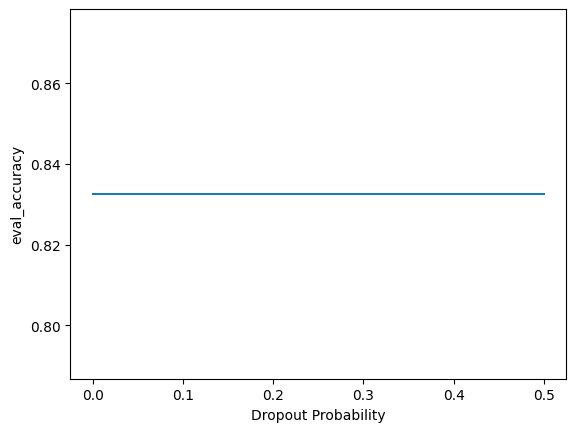

In [22]:
print(acc_drop)
plt.plot([0, 0.1, 0.2, 0.3, 0.4, 0.5],acc_drop)
plt.ylabel('eval_accuracy')
plt.xlabel('Dropout Probability')
plt.show()

In [ ]:
acc_per_model = []

In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, drop_rate=0):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE

          glove_embeddings = np.load("glove.npy")
          embedding_dim = glove_embeddings.shape[1]

          #self.classifier = nn.Linear(embedding_dim, self.num_labels)
          #hidden_size = 128
          self.classifier = nn.Sequential(
              nn.Linear(embedding_dim, self.num_labels),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      avg = torch.mean(embeddings, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=10 , #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-3 ,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
y = []
for log in log_history:
  if 'eval_accuracy' in log:
    y.append(log['eval_accuracy'])
acc_per_model.append(max(y))

In [ ]:

plt.plot(acc_per_model)
plt.ylabel('eval_accuracy')
plt.xlabel('hidden layers')
plt.show()